<a href="https://colab.research.google.com/github/Harsh18999/Machine-Learning-Projects/blob/main/Fake%20News%20Prediction%20(Hackathon%20Competition)/Fake_News_Prediction_Code_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import dependencies**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from bayes_opt import BayesianOptimization
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

##**Import and Read Data**



In [ ]:
data  = pd.read_csv('/content/Steemed data (2).csv')
test_data = pd.read_csv('/content/steemed_test_data (1)')

In [ ]:
# url of given training dataset
url = 'https://drive.google.com/uc?id=1j0SdyJ8gMrLtpFl1gDJ83s41TyUkKqUt'
train_data = pd.read_table(url, sep='\t')

In [ ]:
url = 'https://drive.google.com/uc?id=1fJOaVhtwzQuzpse8OtJSmV5UZjIuR_kN'
test_data = pd.read_csv(url, sep='\t')

In [ ]:
train_data.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


In [ ]:
# null values in data
train_data.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
# shape of data
train_data.shape

(30000, 6)

In [ ]:
# observations of data
train_data['subject'].value_counts()

,count
subject,
politicsNews,7689
worldnews,6833
News,6099
politics,4346
left-news,2953
Government News,1014
US_News,536
Middle-east,530


## **Feature Engineering**

####**A) Feature Construction**

In [ ]:
# methon to calculate sentiment score of text ans title

def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)
    return score['compound']

train_data['sentiment_text'] = train_data['text'].apply(get_sentiment)
train_data['sentiment_title'] = train_data['title'].apply(get_sentiment)

test_data['sentiment_text'] = test_data['text'].apply(get_sentiment)
test_data['sentiment_title'] = test_data['title'].apply(get_sentiment)

In [ ]:
# method to find number of mistakes in text
spell = SpellChecker()

def count_mistakes(txt):
  words = txt.split(' ')
  mistakes = spell.unknown(words)
  return len(mistakes)

data['text_mistakes'] = data['text'].apply(count_mistakes)
data['title_mistakes'] = data['title'].apply(count_mistakes)

test_data['text_mistakes'] = test_data['text'].apply(count_mistakes)
test_data['title_mistakes'] = test_data['title'].apply(count_mistakes)

In [ ]:

def text_length(txt):
  return len(txt.split())

data['text_length'] = data['text'].apply(text_length)
data['title_length'] = data['title'].apply(text_length)

test_data['text_length'] = test_data['text'].apply(text_length)
test_data['title_length'] = test_data['title'].apply(text_length)

In [ ]:
# prevent outlier, create feature (text and mistakes ratio)

data['text_mst_len_ratio'] = data['text_mistakes']/data['text_length']
test_data['text_mst_len_ratio'] = test_data['text_mistakes']/test_data['text_length']

data['title_mst_len_ratio'] = data['title_mistakes']/data['title_length']
test_data['title_mst_len_ratio'] = test_data['title_mistakes']/test_data['title_length']

### **b) Feature Transformation and Analysis**

In [ ]:
# merge text and title
test_data['content'] = test_data['title'] + '.' + test_data['text']

In [ ]:
# function to stem words, remove stopwords (it can take up to 15 - 16 minutes)

stemmer  = PorterStemmer()

def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [stemmer.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

train_data['text'] = train_data['text'].apply(stemming)
train_data['title'] = train_data['title'].apply(stemming)

In [ ]:
data.groupby(['subject']).label.value_counts()

,,count
subject,label,
Government News,0,1014
Middle-east,0,530
News,0,6099
US_News,0,536
left-news,0,2953
politics,0,4346
politicsNews,1,7689
worldnews,1,6833


In [ ]:
data.groupby(['label'])[['text_length', 'title_length','sentiment_title', 'sentiment_text', 'text_mst_len_ratio']].mean()

,text_length,title_length,sentiment_title,sentiment_text,text_mst_len_ratio
label,,,,,
0,244.134514,10.709652,-0.163679,-0.083250,0.216362
1,227.013359,8.080705,-0.066207,0.061893,0.215947


### **Feature Analysis**

* **Sentiment Anaysis :** The get_sentiment function utilizes the SentimentIntensityAnalyzer from the NLTK library to compute the sentiment score of a given text, returning the compound score which indicates the overall sentiment polarity.

* **Grammer and Panchuation Mistakes** count_mistakes function splits the input text into words and uses the SpellChecker library to identify and count the number of misspelled words, returning the total count of mistakes found.

* **Text Stemming** The stemming function preprocesses the input text by removing non-alphabetic characters, converting it to lowercase, splitting it into words, and applying the Porter Stemmer to reduce each word to its root form, while also excluding common English stopwords.

### **Observations:**

* **Imbalanced data distribution :** data is highly imbalanced with respect to the label distribution across different subject categories. Here's a breakdown of why this is the case:

* **Text length :** The average text length for label 0 is approximately 244.13 characters, while for label 1, it is slightly shorter at 227.01 characters. This indicates that texts classified as label 0 tend to be longer on average compared to those classified as label 1.

* **Title length :** The average title length for label 0 is about 10.71 characters, compared to 8.08 characters for label 1. This suggests that titles associated with label 0 are generally longer than those associated with label 1.

* **Title Sentiment :** The sentiment score of the titles shows that label 0 has a negative sentiment score of approximately -0.16, indicating a generally negative sentiment in the titles. In contrast, the sentiment score for label 1 is closer to neutral at -0.07, suggesting that the titles in this category are less negative.

* **Text Sentiment :** For the text sentiment, label 0 has a slightly negative sentiment score of -0.08, while label 1 has a positive sentiment score of 0.06. This indicates that texts classified as label 1 tend to have a more positive sentiment compared to those classified as label 0.

* **Text Mistakes :** The text mistake length ratio is very similar for both labels, with label 0 at approximately 0.216 and label 1 at 0.216 as well. This indicates that the proportion of mistakes relative to the text length does not differ significantly between the two classes.



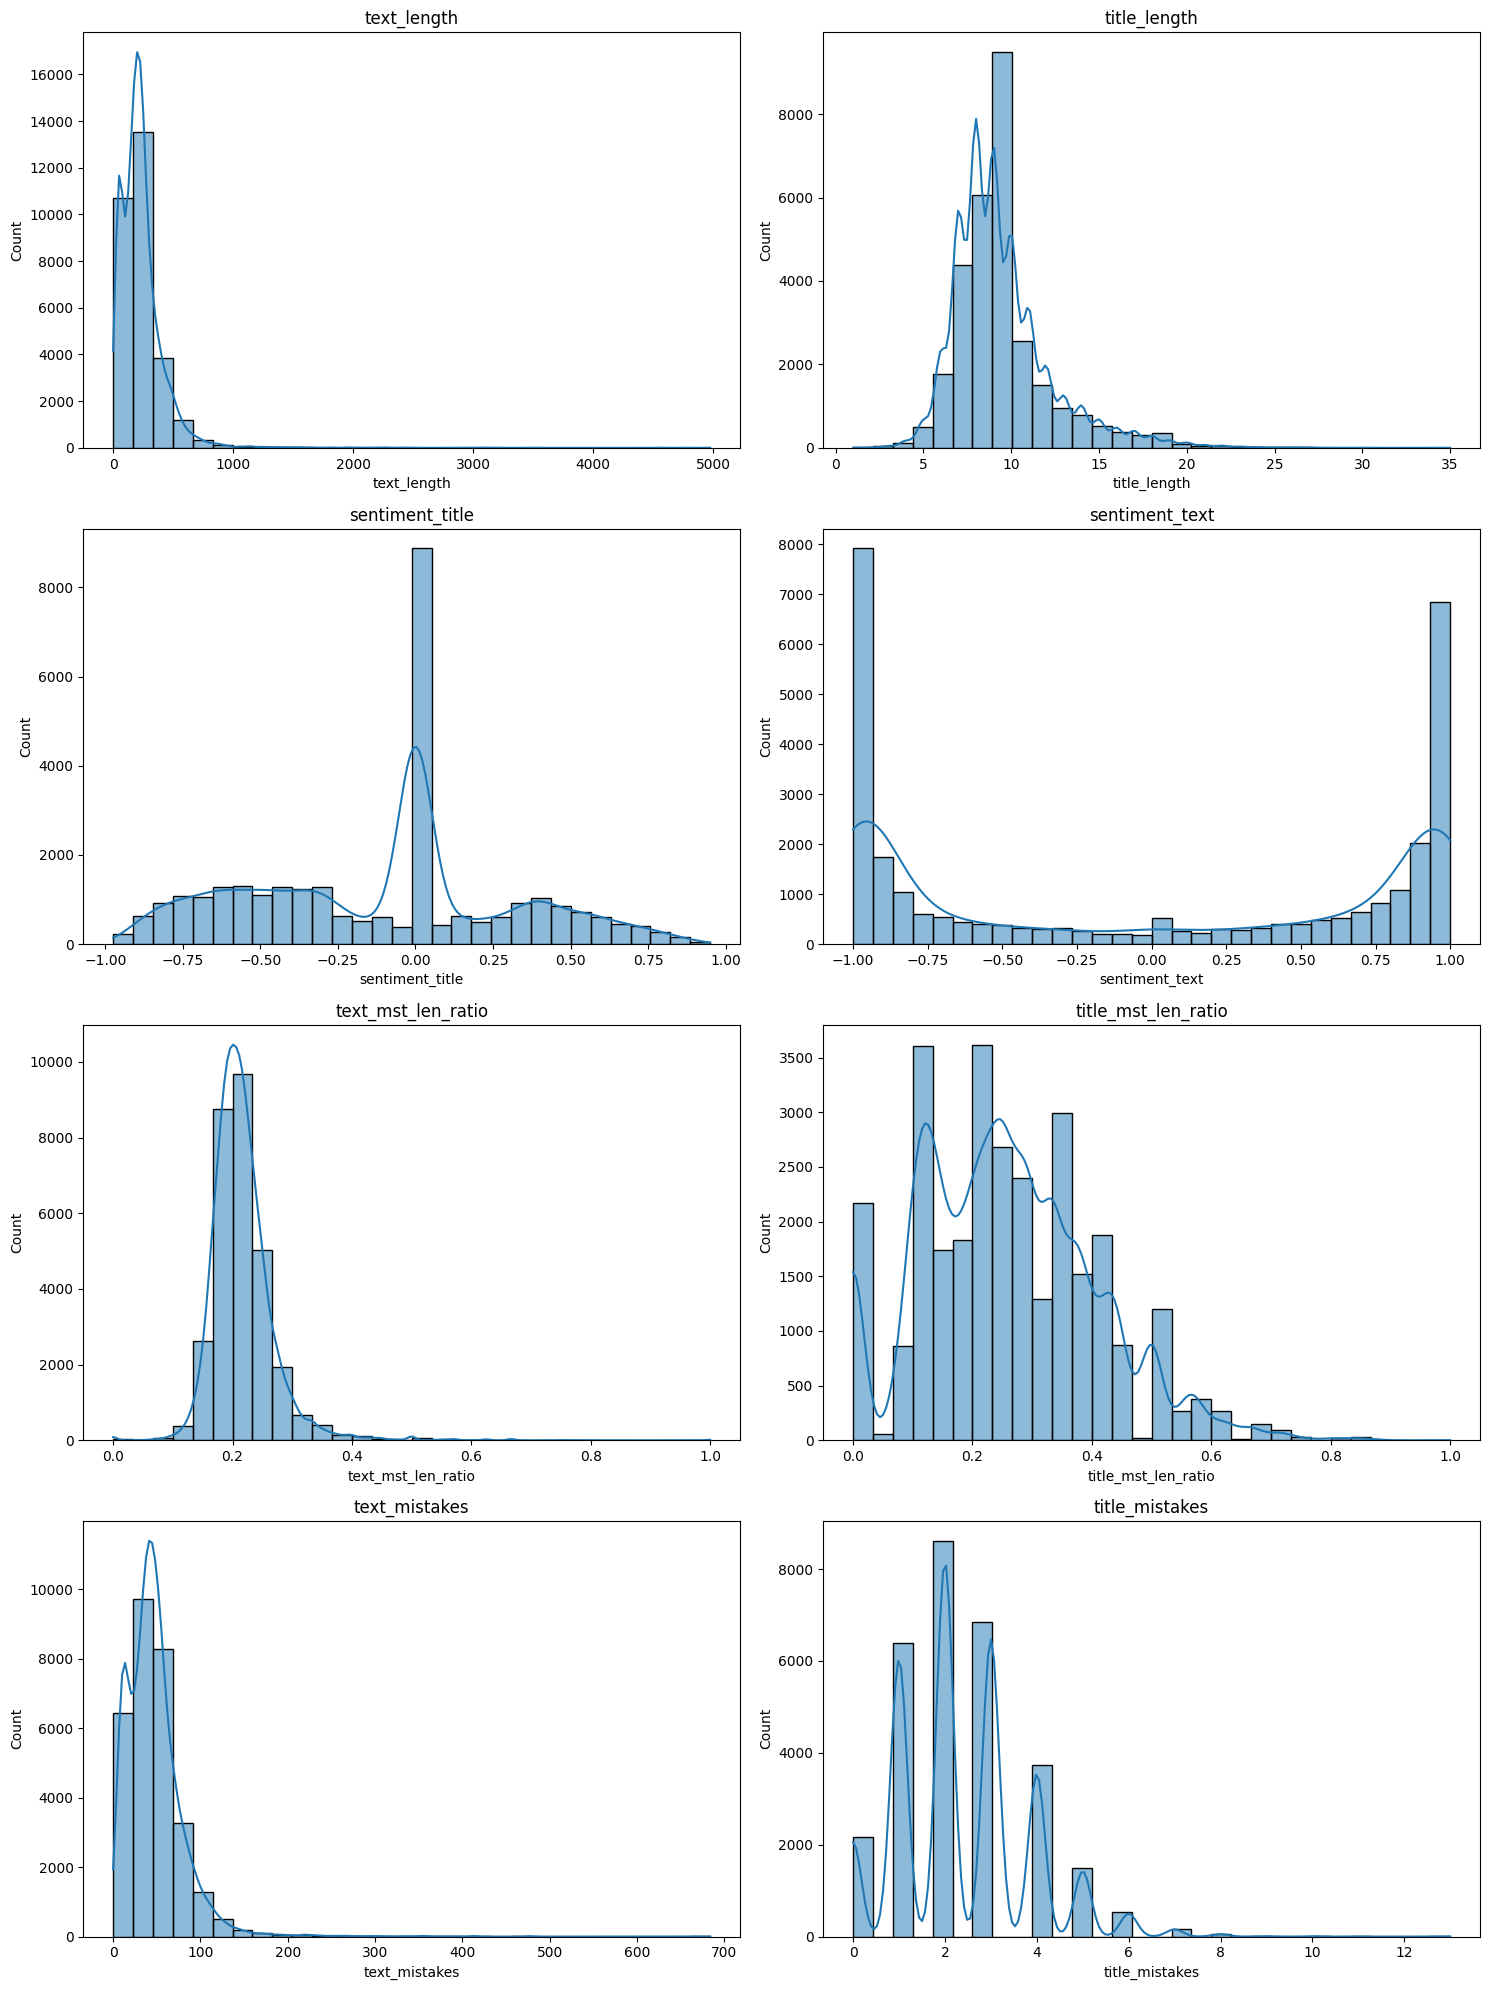

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

int_cols = ['text_length', 'title_length','sentiment_title', 'sentiment_text', 'text_mst_len_ratio', 'title_mst_len_ratio','text_mistakes', 'title_mistakes']
plt.subplots(4, 2, figsize = (15, 20))

for i, col in enumerate(int_cols):
  plt.subplot(4, 2, i+1)
  sns.histplot(data[col], kde=True, bins=30)
  plt.title(col)

plt.tight_layout()
plt.show()


* **Features Capping :** caping on text_mst_len_ratio, text_length, text_mistakes .. etc, has potentially reducing the influence of extreme values on model training and evaluation.

In [ ]:
# outlier handling

data.loc[data['text_mst_len_ratio'] > 0.6, 'text_mst_len_ratio'] = 0.6
test_data.loc[test_data['text_mst_len_ratio'] > 0.6, 'text_mst_len_ratio'] = 0.6

data.loc[data['text_length'] > 1500, 'text_length'] = 1500
test_data.loc[test_data['text_length'] > 1500, 'text_length'] = 1500

data.loc[data['text_mistakes'] > 250, 'text_mistakes'] = 250
test_data.loc[test_data['text_mistakes'] > 250, 'text_mistakes'] = 250

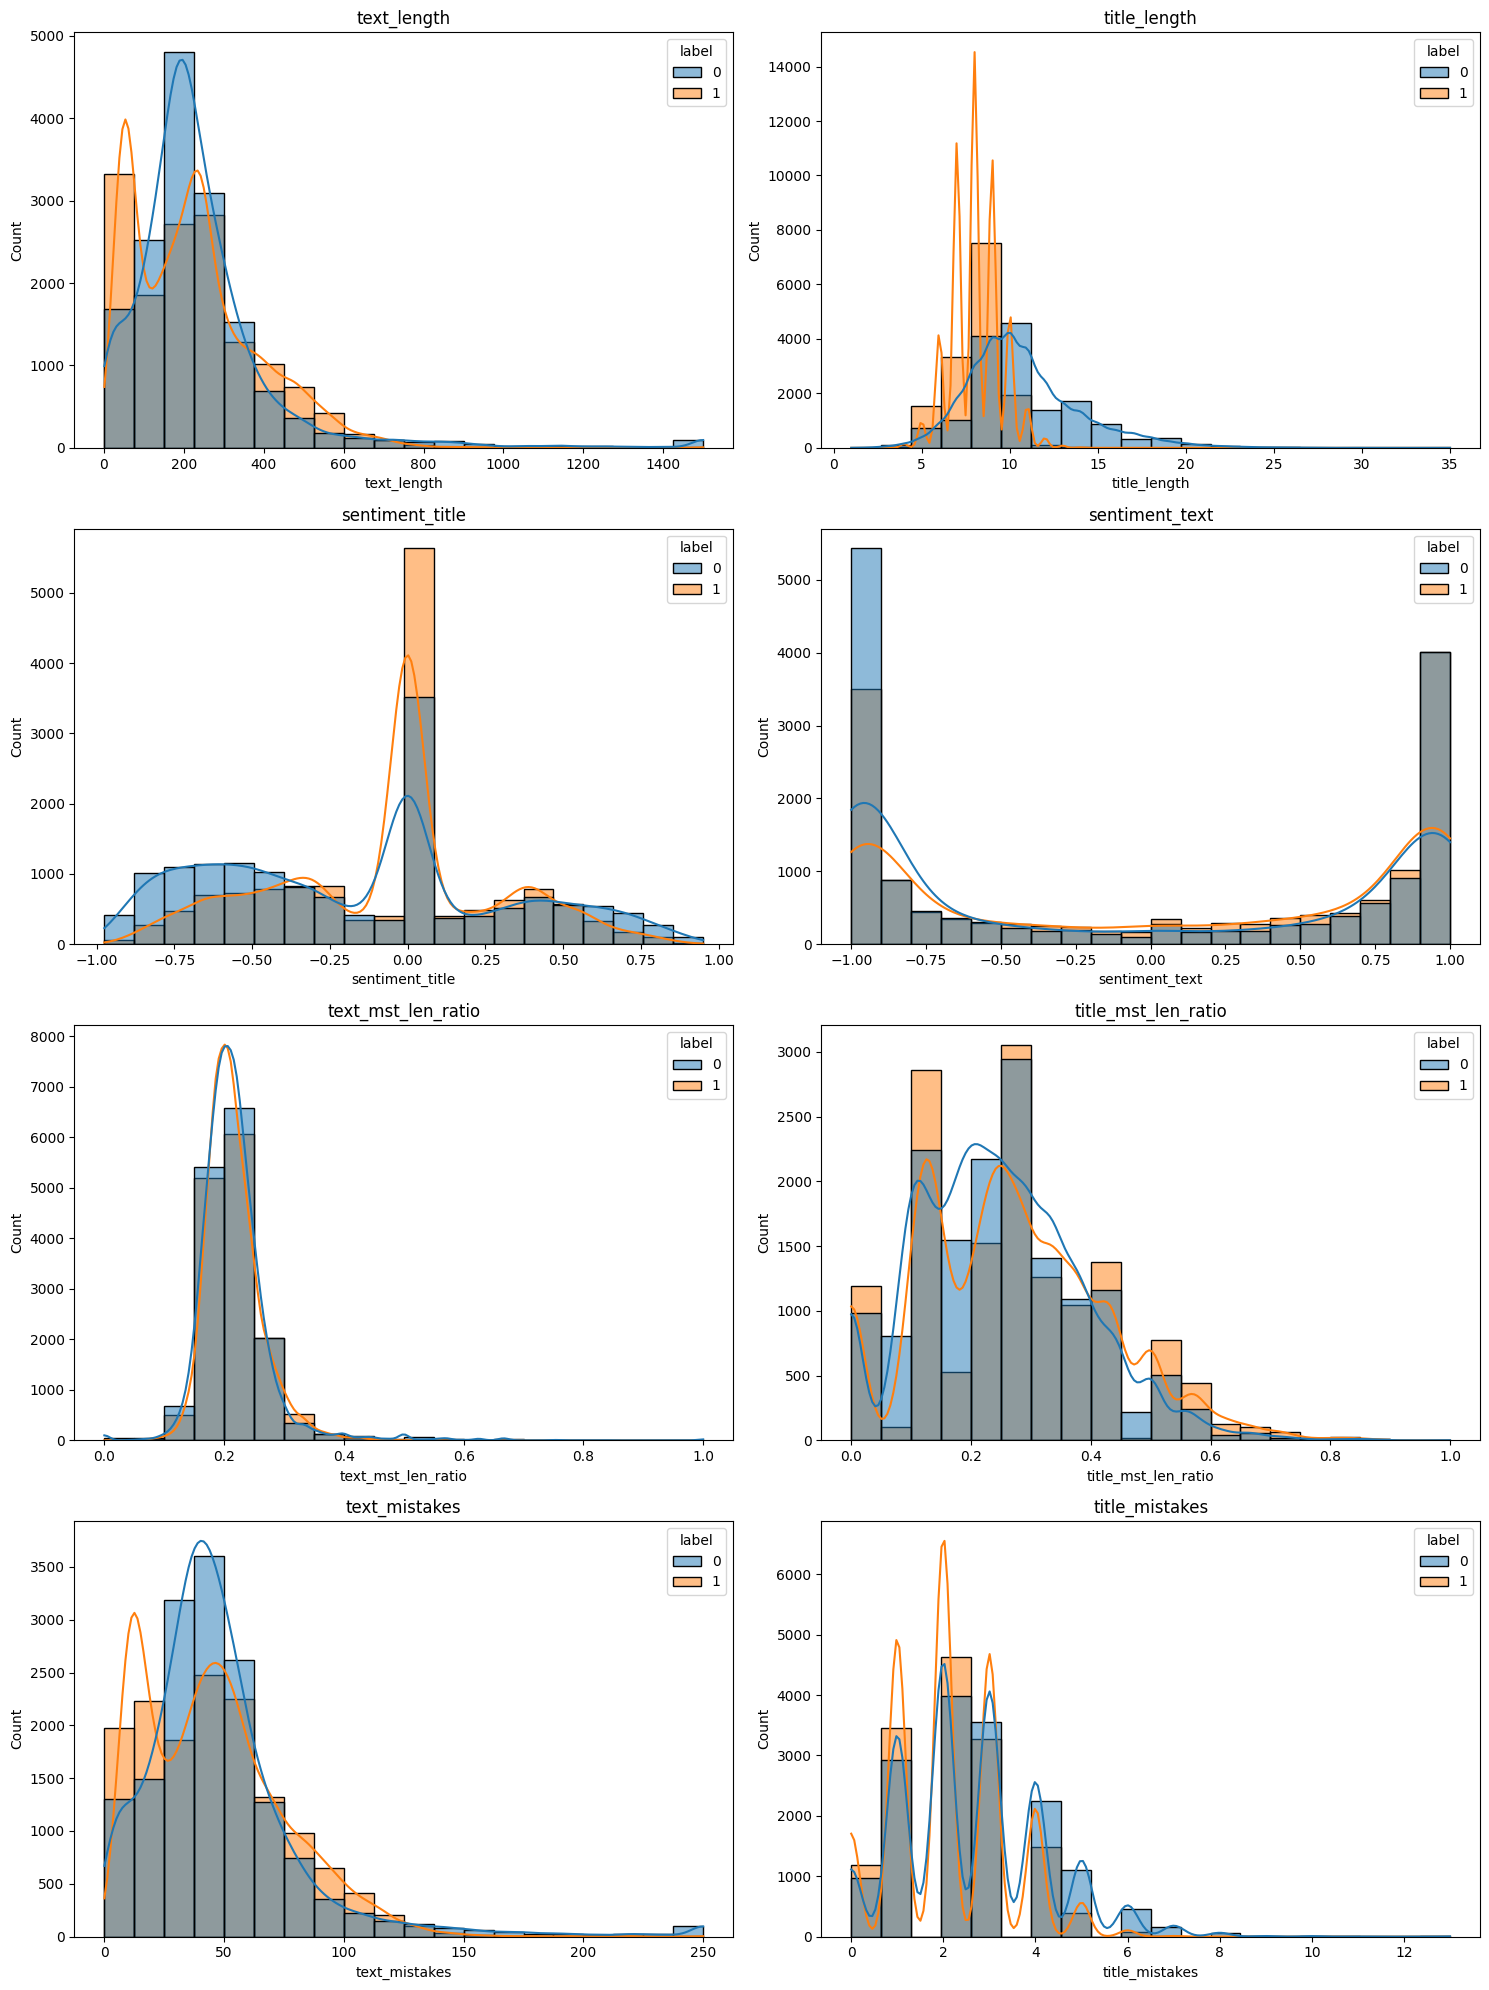

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

int_cols = ['text_length', 'title_length','sentiment_title', 'sentiment_text', 'text_mst_len_ratio', 'title_mst_len_ratio', 'text_mistakes', 'title_mistakes']
plt.subplots(4, 2, figsize = (15, 20))

for i, col in enumerate(int_cols):
  plt.subplot(4, 2, i+1)
  sns.histplot(data=data, x = col, hue='label', kde=True, bins=20,)
  plt.title(col)

plt.tight_layout()
plt.show()

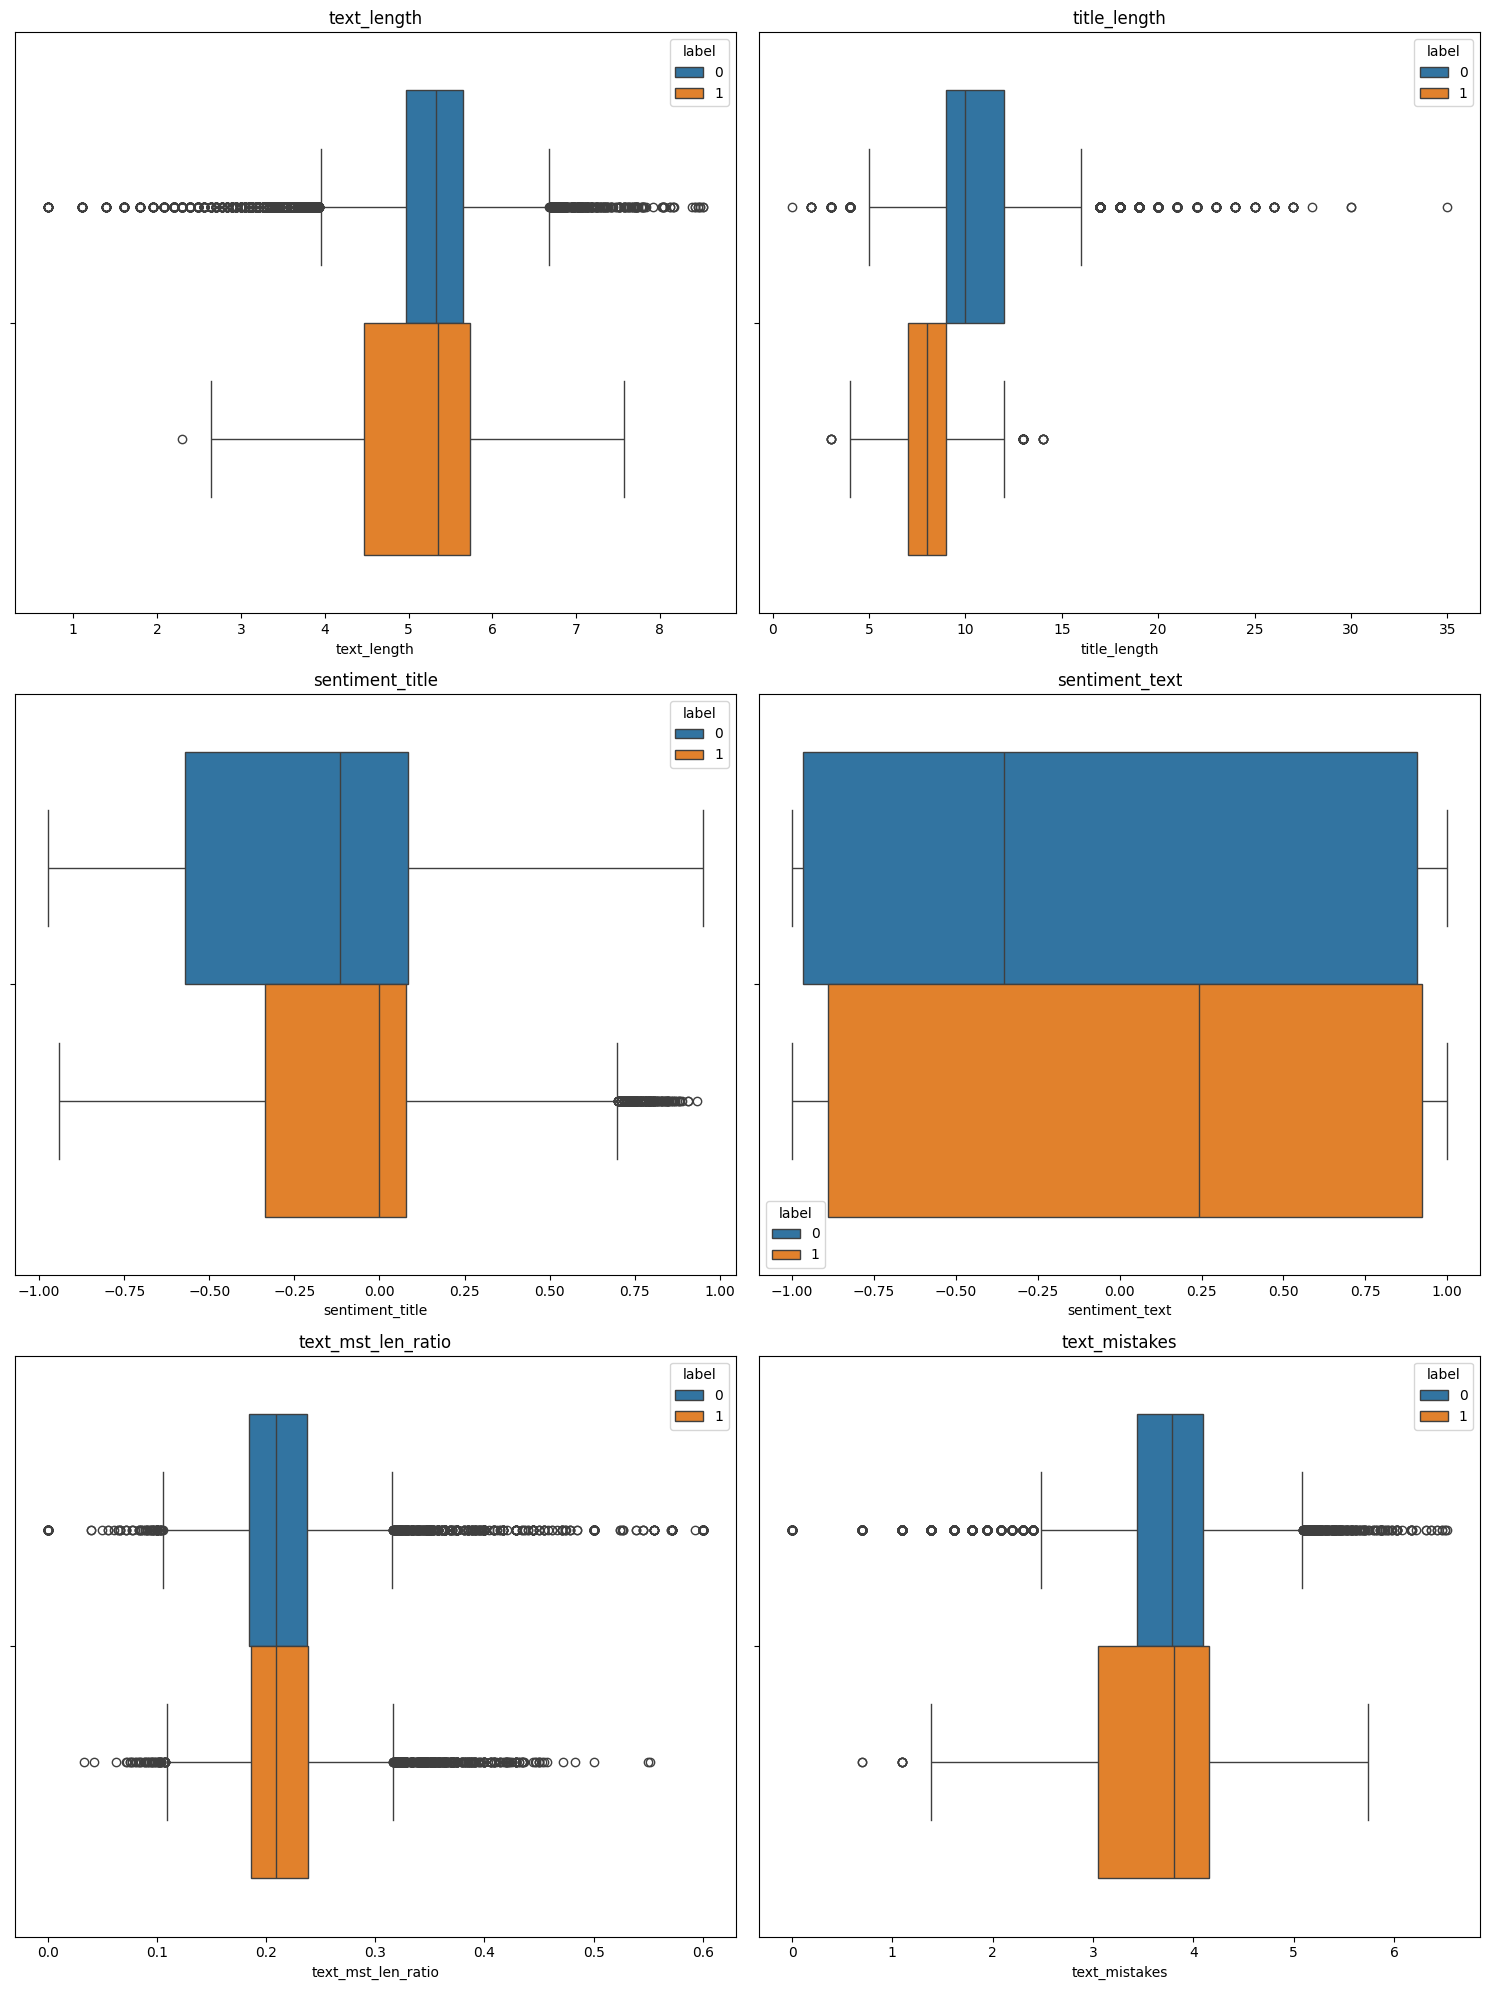

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

int_cols = ['text_length', 'title_length','sentiment_title', 'sentiment_text', 'text_mst_len_ratio', 'text_mistakes']
plt.subplots(3, 2, figsize = (15, 20))

for i, col in enumerate(int_cols):
  plt.subplot(3, 2, i+1)
  sns.boxplot(data=data, hue = 'label', x= col)
  plt.title(col)

plt.tight_layout()
plt.show()

## **Data and Model Prepration**

In [ ]:
data['content'] = data['title'] + ' ' + data['text']
test_data['content'] = test_data['title'] + ' ' + test_data['text']

In [ ]:
cols = ['content', 'text_length', 'title_length','sentiment_title', 'sentiment_text', 'text_mst_len_ratio'] # selected features for model training
X_train = data[cols]
X_test = test_data[cols]

In [ ]:

pre_processor = ColumnTransformer(
    transformers= [
    ('vectorize_text', CountVectorizer(max_features=350, ngram_range=(1,3)), 'content'),
    ('Scaler', StandardScaler(), ['title_length', 'text_length'])

], remainder='passthrough')

pre_processor

ColumnTransformer(remainder='passthrough',
                  transformers=[('vectorize_text',
                                 CountVectorizer(max_features=370,
                                                 ngram_range=(1, 3)),
                                 'content'),
                                ('Scaler', StandardScaler(),
                                 ['title_length', 'text_length'])])

In [ ]:
X_train = pre_processor.fit_transform(X_train)
y_train = data['label']
X_test = pre_processor.transform(X_test)
y_test = test_data['label']

##**Model Selection and Hyperparameter Optimization**

In [ ]:
# bayasian optimization

def xgb_evaluate(subsample, max_depth, learning_rate, colsample_bytree, n_estimators, alpha):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': float(learning_rate),
        'subsample': float(subsample),
        'colsample_bytree': float(colsample_bytree),
        'objective': 'binary:logistic',
        'n_estimators': int(n_estimators),
        'random_state': 42,
        'eval_metric': 'logloss',
        'alpha':float(alpha),
        'lambda':0.0
    }
    model = XGBClassifier(**params)
    cv_score = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy').mean()
    return cv_score
    # Rest of the function

# Set up the bounds for each hyperparameter
pbounds = {
    'subsample': (0.3, 1.0),
    'colsample_bytree': (0.3, 1.0),
    'max_depth': (5, 50),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 250),
    'alpha': (0.1, 3)

}


# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best result found by Bayesian Optimization
print(optimizer.max)


|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9774    | 1.186     | 0.9655    | 0.2223    | 31.94     | 81.2      | 0.4092    |
| 2         | 0.9744    | 0.2684    | 0.9063    | 0.1843    | 36.86     | 54.12     | 0.9789    |
| 3         | 0.9767    | 2.514     | 0.4486    | 0.06273   | 13.25     | 110.8     | 0.6673    |
| 4         | 0.9799    | 1.353     | 0.5039    | 0.1874    | 11.28     | 108.4     | 0.5565    |
| 5         | 0.9785    | 1.423     | 0.8496    | 0.06791   | 28.14     | 168.5     | 0.3325    |
| 6         | 0.9809    | 1.086     | 0.3746    | 0.208     | 11.14     | 108.8     | 0.6503    |
| 7         | 0.9765    | 0.9969    | 0.9031    | 0.108     | 9.803     | 108.8     | 0.5206    |
| 8         | 0.9777    | 0.7519    | 0.8828    | 0.129     | 12.16     | 108.7     | 0.8035    |
| 9         | 0.9792

In [ ]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import logging
import warnings
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found whitespace in feature_names.*")

def lgb_evaluate(num_leaves, max_depth, learning_rate, n_estimators):
    params = {
        'objective': 'binary',
        'metric': 'accuracy',
        'n_estimators': int(n_estimators),
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'verbose': -1,
        'lambda_l1' : 1.5
    }

    # Train the model
    model = lgb.LGBMClassifier(**params)

    # Predict and evaluate
    accuracy = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy').mean()

    return accuracy

# Set up the bounds for each hyperparameter
pbounds = {
    'n_estimators': (20, 150),  # Example range for n_estimators
    'num_leaves': (20, 150),  # Example range for num_leaves
    'max_depth': (5, 50),      # Example range for max_depth
    'learning_rate': (0.05, 0.75) # Example range for learning_rate
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgb_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best result found by Bayesian Optimization
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | 0.978     | 0.3122    | 47.78     | 115.2     | 97.83     |
| 2         | 0.971     | 0.1592    | 12.02     | 27.55     | 132.6     |
| 3         | 0.9756    | 0.4708    | 36.86     | 22.68     | 146.1     |
| 4         | 0.9757    | 0.6327    | 14.56     | 43.64     | 43.84     |
| 5         | 0.978     | 0.263     | 28.61     | 76.15     | 57.86     |
| 6         | 0.9777    | 0.3555    | 31.18     | 87.87     | 63.02     |
| 7         | 0.9785    | 0.4857    | 48.99     | 76.31     | 88.26     |
| 8         | 0.9781    | 0.642     | 49.67     | 77.35     | 89.89     |
| 9         | 0.9758    | 0.7377    | 48.77     | 54.67     | 75.14     |
| 10        | 0.978     | 0.1644    | 26.84     | 78.11     | 84.57     |
| 11        | 0.9781    | 0.5755    | 49.87     | 84.21     | 70.89     |
| 12        | 0.9782    | 0.5141    | 

# **Model Training**

In [ ]:
params =  {'learning_rate': 0.2729385271909664, 'max_depth': 5, 'n_estimators': 149, 'num_leaves': 25, 'lambda_l1' : 1}
lgb_model = lgb.LGBMClassifier(**params)

In [ ]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(lambda_l1=1, learning_rate=0.2729385271909664, max_depth=5,
               n_estimators=149, num_leaves=25)

## **Model Evaluation**

In [ ]:
# predictions of model
y_pred = lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9897181565259465


In [ ]:
# cross validation score

scores = cross_val_score(lgb_model, X_test, y_test, cv=10)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.98548972 0.97944377 0.98669891 0.99153567 0.98065296 0.97218863
 0.98065296 0.98547215 0.98547215 0.97941889]
Mean accuracy: 0.9827025832159764


In [ ]:
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

F1 score: 0.9893363442478987


In [ ]:
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

Precision: 0.9887161484453361


In [ ]:
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.9899573186040673


In [ ]:
cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cfm)

Confusion matrix:
 [[4239   45]
 [  40 3943]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.9897265584616975


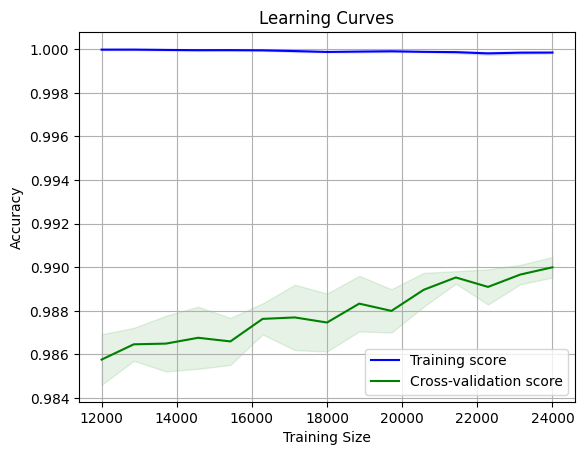

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    lgb_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.5, 1.0, 15), scoring='accuracy'
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curves
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')

# Plotting the standard deviation as a shaded area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)

# Adding titles and labels
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
